# Classifying Types of Raisins with K-Nearest-Neighbours Method
#### Group 53: Sophia Zhang, Pritam Cooner, Jun Lee, Haibin Yu
#### December 7th, 2022

## Introduction

All aspects of the natural life around us are surrounded by patterns and relationships. Although some of these have been discovered, many natural phenomena are unexplainable as of today.  Classification is used to further discern these natural patterns and make sense of our world, it is integral to solving “theoretical and practical applications, [uses] pattern recognition, and image processing” (Xu).  Within this project, we will be aiming to build a prediction model on classifying the type of raisins, Kecimen or Besni, with selected predictors using k-nearest neighbors algorithm (KNN). This algorithm classifies an unknown observation by looking at a certain number of neighbours (k) around the unknown observation and classifying it by whichever class has the majority vote around the unknown observation. This algorithm will be used as it is one of the "simplest and most common classifiers, yet its performance competes with the most complex classifiers" (V. B. Surya Prasath). Within this project we will be utilizing the raisin dataset from UCI Machine Learning Repository. Within this dataset, 900 raisin grains were collected between two types of Turkish raisins, Kecimen and Besni. Image processing was used in this data set, as pictures were taken of these 900 raisins and 7 physical features of the raisins were identified, including the raisin's area, perimeter, length, and more. We use this dataset and identify key features that will allow us to classify whether the raisin is Kecimen or Besni. By doing so, we will show the effectiveness of classification and show how this can be extrapolated to further and more complex phenomena in our world. 


## Methods and Results

## Methods

First of all, we load the necessary packages to access the function from the library and perform some data cleaning. Then, significantly, we use set.seed to make sure that we get the same results for randomization. Similar to the proposal, we load the raisin dataset and split them into a training set (75%) and a testing set (25%). The training set is used for model building, and the testing set is used for model testing on predictive power. After that, we visualize by scatterplots to see which two predictors are highly relative and find “MajorAxisLength” and  “Eccentricity” are suitable for our purpose. With this information, we build our model using the KNN algorithm. We would find the best k value by tuning the classifier and applying cross-validation with different k values from 1 to 100. We find the best k through this progress, build the best KNN model with the best k, predict testing set using the best KNN model, and create the visualization of the analysis. Finally, we check the prediction accuracy of our model and create a confusion matrix.

First, load the packages.

In [23]:
library(repr)
library(tidyverse)
library(tidymodels)

Next, load the raisin dataset, eliminate the metadata, and rename the columns with predictor names.

In [24]:
set.seed(123)
raisin_data <- read.table("data/Raisin_Dataset.arff", sep = ",", skip = 18)
colnames(raisin_data) = c("Area", "Perimeter", "MajorAxisLength", "MinorAxisLength",
                          "Eccentricity", "ConvexArea", "Extent", "Class")
head(raisin_data)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Class
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>
1,87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
2,75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
3,90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
4,45928,286.5406,208.7600,0.6849892,47336,0.6995994,844.162,Kecimen
5,79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
6,49242,318.1254,200.1221,0.7773513,51368,0.6584564,881.836,Kecimen


We split the data into training (75%) and testing (25%).

In [25]:
set.seed(123)
raisin_split <- initial_split(raisin_data, prop = 0.75, strata = Class)  
raisin_train <- training(raisin_split)   
raisin_test <- testing(raisin_split)

Then, we obtain the number of observations grouped by each class for training data.

In [26]:
set.seed(123)
counts <- raisin_train |>
            group_by(Class) |>
            summarize(n = n())
counts

Class,n
<chr>,<int>
Besni,337
Kecimen,337


Examine the mean of the predictors for training data.

In [27]:
set.seed(123)
mean_pred <- raisin_train |>
                select(-Class) |>
                map_dfr(mean)
mean_pred

Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
87023.82,429.1558,253.922,0.7816062,90340.22,0.6990537,1162.402


Check if we have any missing data.

In [28]:
sum(is.na(raisin_train))

[1] 0

Visualize the relationship between two predictors, Area and Eccentricity, in a scatterplot using training data. It is important to note that eccentricity defines the the amount of devaiton the raisin shows from being circular, and area was measured as the number of pixels that would fit on the raisin.

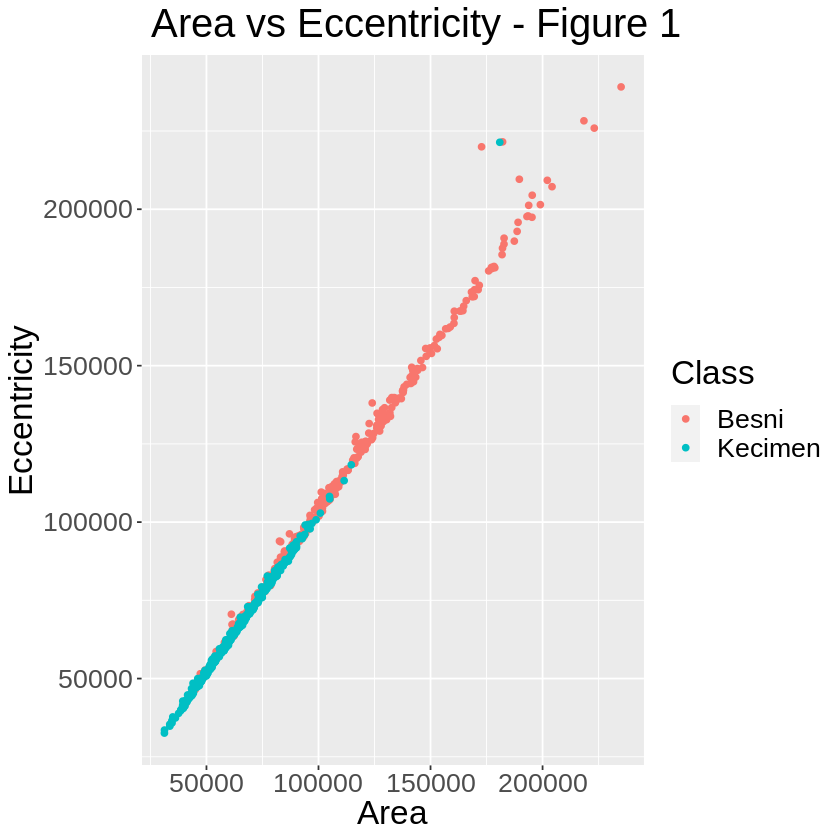

In [29]:
set.seed(123)
raisin_train |>
    ggplot(aes(x = Area, y = Eccentricity,color = Class)) +
    geom_point() +
    labs(x = "Area", y = "Eccentricity") +
    ggtitle(" Area vs Eccentricity - Figure 1")+
    theme(text = element_text(size = 20))


According to the scatterplot, there are many overlaps between the two classes. The two factors "Eccentricity" and "Area" are not good predictors together for building model.

Now lets take a look at predictors "MajorAxisLength" and "Eccentricity". In this data set "MajorAxisLength" represents the length of the raisin which is determined by the longest line that is able to be drawn on the raisin. 

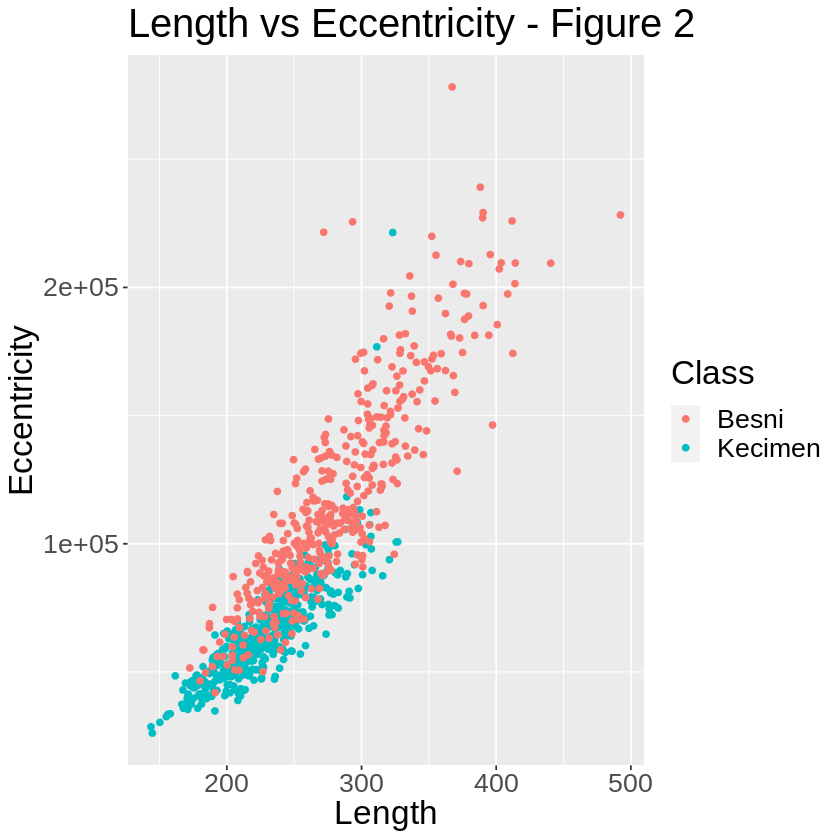

In [30]:
set.seed(123)
len_vs_ecc <- raisin_data |>
    ggplot(aes(x = MajorAxisLength, y = Eccentricity,color = Class)) +
    geom_point() +
    labs(x = "Length", y = "Eccentricity") +
    ggtitle("Length vs Eccentricity - Figure 2")+
    theme(text = element_text(size = 20))
len_vs_ecc


The discrimination between the “MajorAxisLength” and “Eccentricity” are relatively high, so they are good predictors for building models. 

Now, we start to build our prediction model and train it.

First of all, due to the large difference between data and figures, let's talk about "scale" all the data. Secondly, the validation data feed the model with fresh information that it hasn't previously assessed during training. Before applying the model to analyse the test set, we may assess how well it generates predictions using validation data, which serves as the initial test against unobserved data.
Here, we use k nearest neighbor to predict. For data visualization, we use the trend chart (Figure 3) and we just need to find the K value of the highest point and use it. If it is difficult to find it in the figure, you can also make more accurate confirmation in the following table. Also, since we want to assess neighbours from 1 to 100, and examine they one by one would be extremely computationally expensive, so we set the interval of 5. Based on Figure 3, k=26 is the highest point. However, choosing an even number might result in a tie between the votes on the nearest neighbours, so we use k=27 to avoid this scenario and hence make our model more accurate.


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7417691,5,0.009084638,Preprocessor1_Model01
6,accuracy,binary,0.8263169,5,0.010987898,Preprocessor1_Model02
11,accuracy,binary,0.8352283,5,0.008314733,Preprocessor1_Model03
16,accuracy,binary,0.8411106,5,0.013768582,Preprocessor1_Model04
21,accuracy,binary,0.8396620,5,0.014094658,Preprocessor1_Model05
26,accuracy,binary,0.8441176,5,0.013787865,Preprocessor1_Model06
31,accuracy,binary,0.8411106,5,0.013382297,Preprocessor1_Model07
36,accuracy,binary,0.8411326,5,0.014134107,Preprocessor1_Model08
41,accuracy,binary,0.8411326,5,0.015451769,Preprocessor1_Model09


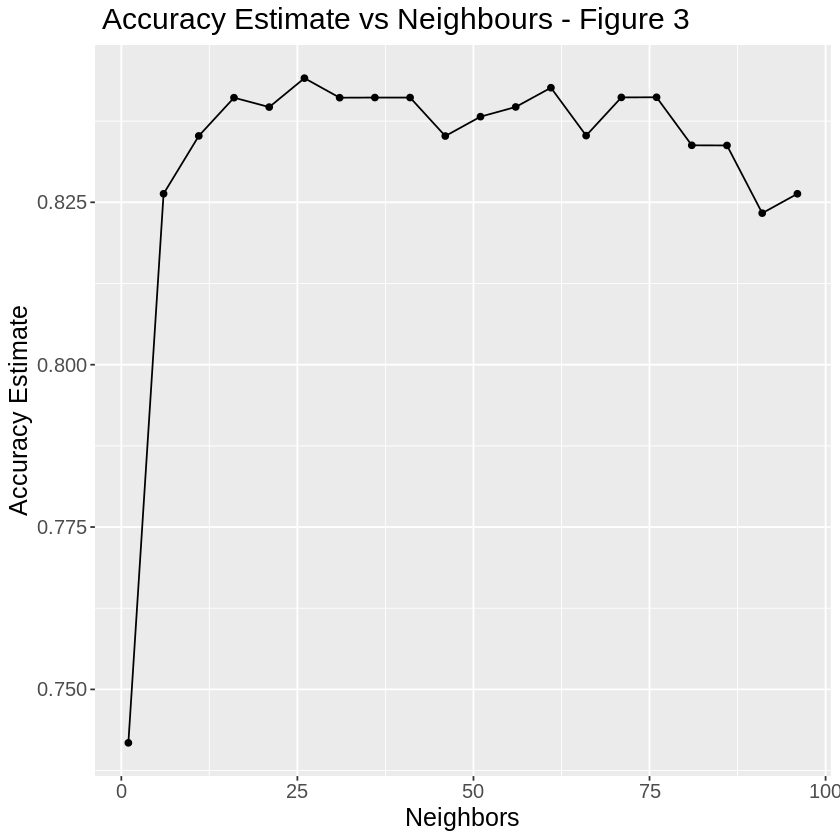

In [31]:
set.seed(123)

raisin_recipe <- recipe(Class ~ MajorAxisLength + Eccentricity, data = raisin_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


raisin_vfold <- vfold_cv(raisin_train, v = 5, strata = Class)

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(raisin_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = raisin_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle(" Accuracy Estimate vs Neighbours - Figure 3") +
  theme(text = element_text(size = 15))

accuracy_vs_k

Now, we find that our prediction accuracy is the highest when k=27 through validation. We now use the same code except validation to predict our test data by substituting k=27.

In [32]:
set.seed(123)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 27) |>
  set_engine("kknn") |>
  set_mode("classification")

raisin_data_recipe_2 <- recipe(Class ~ MajorAxisLength + Eccentricity, data = raisin_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())

raisin_fit <- workflow() |>
  add_recipe(raisin_data_recipe_2) |>
  add_model(knn_spec) |>
  fit(data = raisin_train)

raisin_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(27,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1557864
Best kernel: rectangular
Best k: 27

In [33]:
set.seed(123)
raisin_test_predictions <- predict(raisin_fit, raisin_test) |>  
    bind_cols(raisin_test) |>
    mutate(Class = as.factor(Class)) 

head(raisin_test_predictions)
tail(raisin_test_predictions)

.pred_class,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Class
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>
Besni,87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
Kecimen,90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
Kecimen,79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
Kecimen,43441,276.6108,201.8131,0.6838823,45133,0.6908556,803.748,Kecimen
Kecimen,33565,261.5543,167.7085,0.7673743,35794,0.6815505,751.413,Kecimen
Kecimen,57346,330.4784,222.4437,0.7395550,59365,0.7236088,928.272,Kecimen


.pred_class,Area,Perimeter,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Class
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<fct>
Besni,179668,690.4334,332.5533,0.8763589,181954,0.7794031,1681.985,Besni
Kecimen,66938,356.3233,248.6742,0.7162055,69880,0.7086611,1022.705,Besni
Besni,97494,451.7828,278.2800,0.7877776,101878,0.6896957,1254.755,Besni
Besni,171264,609.6431,359.2246,0.8079599,174156,0.7717376,1592.095,Besni
Besni,110936,500.9313,286.2524,0.8206436,113888,0.7323959,1319.435,Besni
Besni,85646,469.7748,238.5394,0.8614903,92673,0.6810436,1226.892,Besni


Finally, we compare the results of our test data prediction through metrics. The point with the same name where the abscissa and ordinate intersect represents accurate data, on the contrary, it is data that we have not predicted correctly. Since we only need accuracy, we only select "accuracy" with "filter".

## Results 

Based on the constructed KNN model with k=27, we obtain the overall prediction accuracy of 87.17%.

In [34]:
set.seed(123)
accuracy <- raisin_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |> 
    filter(.metric == "accuracy")

accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8716814


Below is the Confusion Matrix to showcase the predicted result on each type of raisin.

In [35]:
set.seed(123)
Confusion_Matrix<-raisin_test_predictions |>
    conf_mat(truth = Class, estimate = .pred_class)

Confusion_Matrix

          Truth
Prediction Besni Kecimen
   Besni      93       9
   Kecimen    20     104

Below is the prediction accracy rate for each type of raisin.

In [36]:
Besni_rate <- 93/(93+20)
Kecimen_rate <- 104/(104+9)
Besni_rate
Kecimen_rate

[1] 0.8230088

[1] 0.920354

## Discussion

By building a KNN classification model with the best k value (k=27) and predictors "MajorAxisLength" and "Eccentricity" using the training data, we expect to have high prediction accuracy on the testing data in classifying raisins. Here, we have the prediction accuracy of around 87.17%, which is relatively high and meets our expectation. Based on the confusion matrix, the prediction accuracy rate for Besni raisin (82.30%) is lower than the prediction accuracy rate for Kecimen raisin (92.04%). 

The impacts of these findings are, when raisin images that are unclear and low resolution are encountered, with data collected on "MajorAxisLength" and "Eccentricity", we can predict the class of raisin with high accuracy. Further research could explore on selecting the best 2 predictors on improving the prediction accuracy instead of just using "MajorAxisLength" and "Eccentricity". It can be accomplished by utilizing the random forest method as follows. By looking at figure 4 below, the top two variables in terms of Mean Decrease Gini are "Extent" and "Perimeter". In other words, these are the two most important variables. Perhaps in further studies, we can improve the model on prediction accuracy by using "Extent" and "Perimeter" as the two predictors. Moreover, we can also try to add more predictors and find the best model on prediction accuracy.

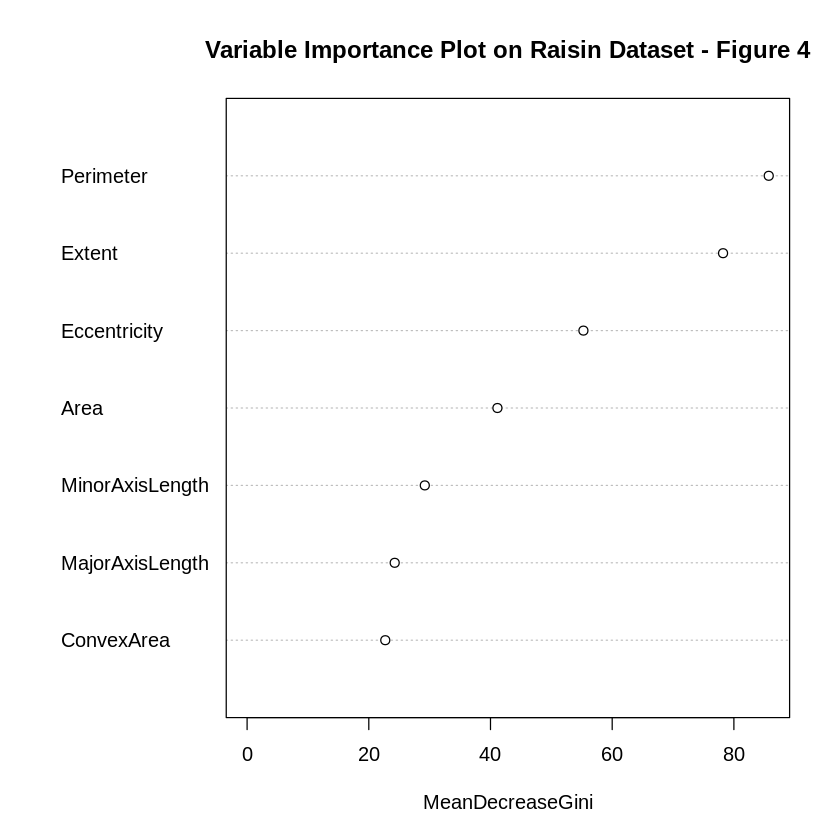

In [37]:
library(dplyr)
library(randomForest)

raisin_train$Class <- as.factor(raisin_train$Class)
rf <- randomForest(Class ~ ., data = raisin_train, proximity = TRUE) 
varImpPlot(rf, main = "Variable Importance Plot on Raisin Dataset - Figure 4")

## References

Prasatha, V. S., et al. "Effects of distance measure choice on knn classifier performance-a review." arXiv preprint arXiv:1708.04321 (2017): 56.

Xu, Xiaobin. “Data Classification Using Evidence Reasoning Rule.” ScienceDirect.com | Science, Health and Medical Journals, Full Text Articles and Books., www.sciencedirect.com/. 

UCI Machine Learning Repository: Raisin Dataset Data Set, https://archive.ics.uci.edu/ml/datasets/Raisin+Dataset. 